# YLearn Case Study - Bank customer transaction amount

## Content

1. Summary
1. Dataset
1. Causal Effect with Card_Category
    1. Learn Why
    1. Estimate Causal Effect
    1. Whatif & Policy interpret    
1. Causal Effect with noise data
1. Learn Why with Causal Discovery
1. Conclusion

## 1. Summary

In any commercial fields, it is crucial to retain customers and make policies to reduce customer churn, which as reported bring large profit and extra values to the company. A credit department of bank provides multiple services to customers. The policy maker would like to know which services attract customers the most and what characteristics they have in order to develop targeted programs to improve customer retention.

YLearn provides a complete causal problem-solving routine. It first filters tens of important features among numerous variables and then discover the causal relations between these features. Causal model and estimator model are used to identify and estimate the causal effects of interested features respectively. With the help of effect interpreter library, users could visually understand the eatimation process of causal effects. Besides, users are able to manipulate the data to perform counterfactual predictions via whatif function. To be a wise decision maker, the last step is to apply the policy interpreter which provides the optimized solutions to the target outcome. (if set the goal, or set the constrains).

## 2. Dataset

The dataset used in this notebook is a subset of Kaggle [BankChurners](https://www.kaggle.com/datasets/syviaw/bankchurners) dataset. It contains the information of around 10,000 customers with the  features below:

* Customer general features: Customer_Age, Gender, Dependent_count, Education_Level, Marital_Status,  Income_Category
* Customer credit card features: Months_on_book, Card_Category, Credit_Limit
* Customer transaction amount: Total_Trans_Amt

The `Total_Trans_Amt` is the outcome in this notebook.


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot  as plt

from sklearn.model_selection import train_test_split
from ylearn import Why

In [2]:
df = pd.read_csv('data/BankChurners.csv.zip')
cols = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 
        'Months_on_book', 'Card_Category', 'Credit_Limit',  
        'Total_Trans_Amt' 
     ]
data = df[cols]
outcome = 'Total_Trans_Amt'

data 

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book,Card_Category,Credit_Limit,Total_Trans_Amt
0,45,M,3,High School,Married,$60K - $80K,39,Blue,12691.0,1144
1,49,F,5,Graduate,Single,Less than $40K,44,Blue,8256.0,1291
2,51,M,3,Graduate,Married,$80K - $120K,36,Blue,3418.0,1887
3,40,F,4,High School,Unknown,Less than $40K,34,Blue,3313.0,1171
4,40,M,3,Uneducated,Married,$60K - $80K,21,Blue,4716.0,816
...,...,...,...,...,...,...,...,...,...,...
10122,50,M,2,Graduate,Single,$40K - $60K,40,Blue,4003.0,15476
10123,41,M,2,Unknown,Divorced,$40K - $60K,25,Blue,4277.0,8764
10124,44,F,1,High School,Married,Less than $40K,36,Blue,5409.0,10291
10125,30,M,2,Graduate,Unknown,$40K - $60K,36,Blue,5281.0,8395


In [3]:
train_data,test_data=train_test_split(data,test_size=0.3,random_state=123)

print('train_data:',train_data.shape)
print('test_data: ',test_data.shape)

train_data: (7088, 10)
test_data:  (3039, 10)


# Causal Effect with `Card_Category`


## Inspect customers with various credit cards

Total_Trans_Amt      
                         mean count
Card_Category                      
Blue              4231.481184  6590
Silver            6743.212121   396
Gold              7516.448276    87
Platinum          8047.133333    15

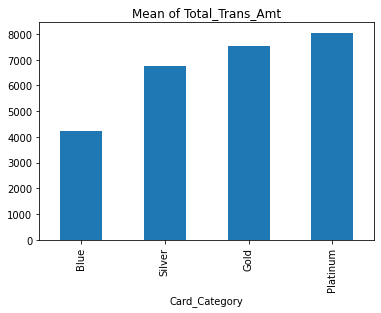

In [4]:
card_stat=train_data[['Card_Category','Total_Trans_Amt']].groupby('Card_Category').agg(['mean','count']).sort_values(by=('Total_Trans_Amt','mean'))

card_stat[('Total_Trans_Amt','mean')].plot(kind='bar', title='Mean of Total_Trans_Amt')
card_stat

## Learn Why with `treatment='Card_Category'`

In [5]:
why=Why()
why.fit(train_data,outcome,treatment='Card_Category')

07-05 14:34:30 I ylearn._why.py 474 - infer outcome as regression
07-05 14:34:30 I ylearn._why.py 484 - identify treatment, adjustment, covariate and instrument
07-05 14:34:30 I ylearn._why.py 610 - infer discrete_treatment=True
07-05 14:34:30 I ylearn._why.py 625 - identified adjustment: None
07-05 14:34:30 I ylearn._why.py 626 - identified covariate: ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Credit_Limit']
07-05 14:34:30 I ylearn._why.py 627 - identified instrument: None
07-05 14:34:30 I ylearn._why.py 493 - encode treatment ...
07-05 14:34:30 I ylearn._why.py 503 - preprocess data ...
07-05 14:34:30 I ylearn._why.py 521 - fit estimator for Card_Category with PermutedTLearner(model=GradientBoostingRegressor(max_depth=100), random_state=2022, kwargs=None)


Why(discrete_outcome=False, discrete_treatment=True)

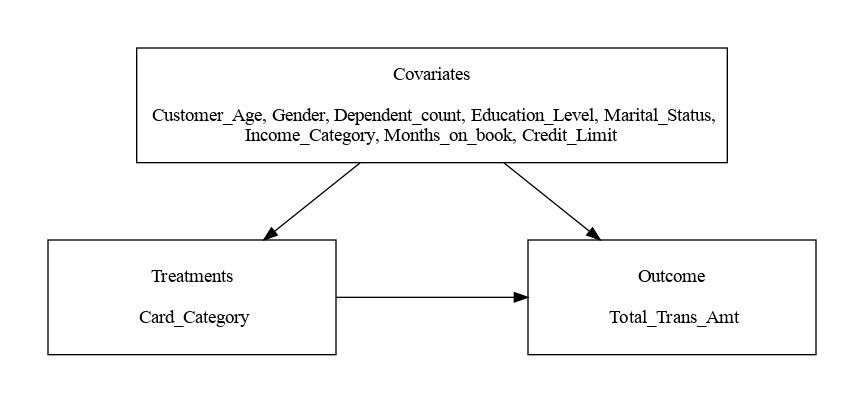

In [6]:
why.plot_causal_graph()

## Estimate causal effect

,mean,min,max,std
Gold vs Blue,7879.761014,-15134.510740,15304.622191,5427.989114
Platinum vs Blue,3698.362357,-15575.484931,16067.674561,5733.207134
Silver vs Blue,1389.101262,-16030.507479,15200.662955,5474.555212


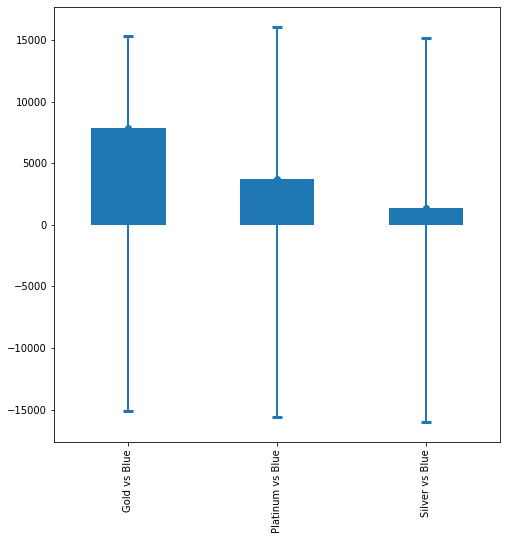

In [7]:
effect=why.causal_effect(control='Blue')
effect=effect.loc['Card_Category']

plt.figure(figsize=(8, 8))

err =  [ (effect['mean'] - effect['min']).values,  
          (effect['max'] - effect['mean']).values,
        ]
plt.errorbar(effect.index, effect['mean'].values, yerr=err,  fmt='o', capsize=5, capthick=3, barsabove=True,elinewidth=2)
effect['mean'].plot(kind='bar')

effect

## Whatif

* Upgrade all **Blue** cards to **Sliver**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Silver card:	5651.153


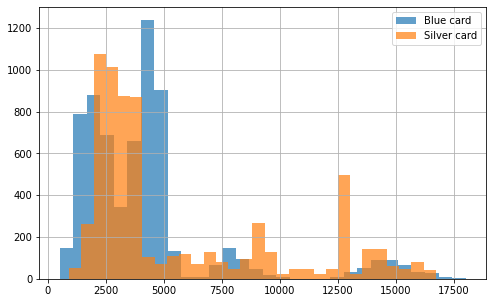

In [8]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_sliver=whatif_data['Card_Category'].map(lambda _:'Silver')
out_silver=why.whatif(whatif_data,value_sliver,treatment='Card_Category')

print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Silver card:\t{out_silver.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_silver.hist(label='Silver card',bins=30,alpha=0.7)
plt.legend()

* Upgrade all **Blue** cards to **Gold**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Gold card:	12477.160


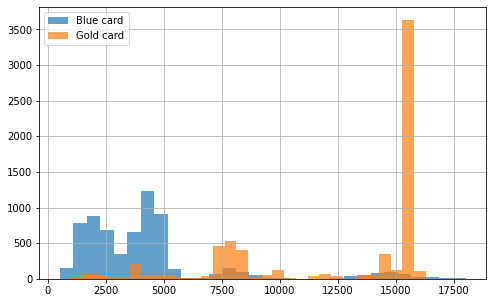

In [9]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_gold=whatif_data['Card_Category'].map(lambda _:'Gold')
out_gold=why.whatif(whatif_data,value_gold,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Gold card:\t{out_gold.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_gold.hist(label='Gold card',bins=30,alpha=0.7)
plt.legend()

* Upgrade all **Blue** cards to **Platinum**

Selected customers: 6590
Mean Total_Trans_Amt with Blue card:	4231.481
Mean Total_Trans_Amt if Platinum card:	8044.294


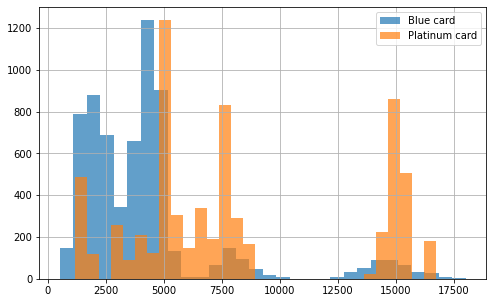

In [10]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_platinum=whatif_data['Card_Category'].map(lambda _:'Platinum')
out_platinum=why.whatif(whatif_data,value_platinum,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean {outcome} if Platinum card:\t{out_platinum.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_platinum.hist(label='Platinum card',bins=30,alpha=0.7)
plt.legend()

## Causal policy interprete

07-05 14:34:39 I ylearn.p.policy_model.py 452 - Start building the policy tree with criterion PRegCriteria
07-05 14:34:39 I ylearn.p.policy_model.py 468 - Building the policy tree with splitter BestSplitter
07-05 14:34:39 I ylearn.p.policy_model.py 511 - Building the policy tree with builder DepthFirstTreeBuilder


[Text(0.5, 0.8333333333333334, 'Credit_Limit <= 15507.0\nsamples = 6590\nvalue = [[0.0]\n[8245.679]\n[3812.813]\n[1419.671]]'),
 Text(0.25, 0.5, 'Credit_Limit <= 15231.5\nsamples = 5740\nvalue = [[0.0]\n[9130.243]\n[3888.034]\n[1389.85]]'),
 Text(0.125, 0.16666666666666666, 'samples = 5727\nvalue = [[0.0]\n[9139.36]\n[3890.432]\n[1378.435]]'),
 Text(0.375, 0.16666666666666666, 'samples = 13\nvalue = [[0.0]\n[5113.623]\n[2831.457]\n[6418.655]]'),
 Text(0.75, 0.5, 'Months_on_book <= 34.5\nsamples = 850\nvalue = [[0.0]\n[2272.272]\n[3304.85]\n[1621.056]]'),
 Text(0.625, 0.16666666666666666, 'samples = 287\nvalue = [[0.0]\n[1486.319]\n[101.333]\n[3001.451]]'),
 Text(0.875, 0.16666666666666666, 'samples = 563\nvalue = [[0.0]\n[2672.927]\n[4937.904]\n[917.373]]')]

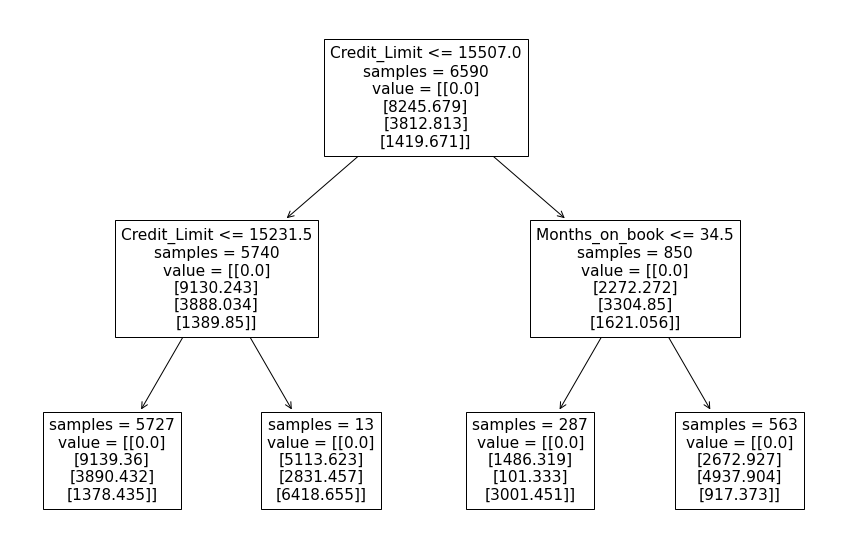

In [11]:
pi=why.policy_interpreter(whatif_data,  max_depth=2)

plt.figure(figsize=(15, 10), )
pi.plot()

* Upgrade credit card with causal policy

In [12]:
why.x_encoders_['Card_Category'].classes_

array(['Blue', 'Gold', 'Platinum', 'Silver'], dtype=object)

In [13]:
def card_from_policy(row):
    # print(row,type(row))
    credit_limit=  row['Credit_Limit']
    months_on_book =  row['Months_on_book']
    if credit_limit <= 15507.0:        
        if credit_limit <= 15231.5:
            return 'Gold'
        else:
            return 'Silver'
    else:
        if months_on_book<=34.5:
            return 'Silver'
        else:
            return 'Platinum' 

Selected customers: 6590
Mean of Total_Trans_Amt with Blue card:	4231.481
Mean of Total_Trans_Amt if apply policy:	12739.222


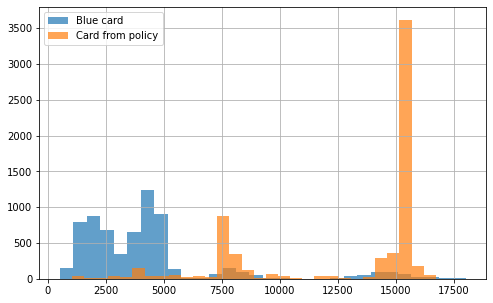

In [14]:
whatif_data= train_data[lambda df: df['Card_Category']=='Blue' ]
out_orig=whatif_data[outcome]

value_from_policy=whatif_data.apply(card_from_policy,axis=1)
out_from_policy=why.whatif(whatif_data,value_from_policy,treatment='Card_Category')


print('Selected customers:', len(whatif_data))
print(f'Mean of {outcome} with Blue card:\t{out_orig.mean():.3f}' )
print(f'Mean of {outcome} if apply policy:\t{out_from_policy.mean():.3f}' )

plt.figure(figsize=(8, 5), )
out_orig.hist(label='Blue card',bins=30,alpha=0.7)
out_from_policy.hist(label='Card from policy',bins=30,alpha=0.7)
plt.legend()

## Effect comparation

,Mean of Total_Trans_Amt
Blue to Silver,5651.152584
Blue to Gold,12477.160069
Blue to Platinum,8044.293858
Card from Policy,12739.222379


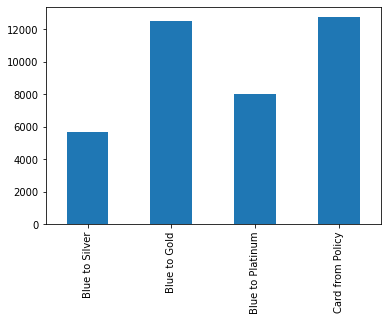

In [15]:
whatif_summary=pd.Series({
    'Blue to Silver': out_silver.mean(),
    'Blue to Gold': out_gold.mean(),
    'Blue to Platinum': out_platinum.mean(),
    'Card from Policy': out_from_policy.mean(),
    },name=f'Mean of {outcome}').to_frame()
whatif_summary.plot(kind='bar',legend=False)
whatif_summary

# 5. Learn Why with Causal Discovery

## Learn Why with treatment=None

In [16]:
why=Why(random_state=123)
why.fit(train_data,outcome)

07-05 14:34:40 I ylearn._why.py 474 - infer outcome as regression
07-05 14:34:40 I ylearn._why.py 484 - identify treatment, adjustment, covariate and instrument
07-05 14:34:40 I ylearn.s._transformer.py 132 - preprocessing
07-05 14:34:40 I ylearn.s._transformer.py 134 - scoring
07-05 14:34:40 I ylearn._why.py 598 - identified treatment[classification]: ['Gender', 'Education_Level']
07-05 14:34:40 I ylearn._why.py 610 - infer discrete_treatment=True
07-05 14:34:40 I ylearn._why.py 625 - identified adjustment: None
07-05 14:34:40 I ylearn._why.py 626 - identified covariate: ['Customer_Age', 'Dependent_count', 'Marital_Status', 'Income_Category', 'Months_on_book', 'Card_Category', 'Credit_Limit']
07-05 14:34:40 I ylearn._why.py 627 - identified instrument: None
07-05 14:34:40 I ylearn._why.py 493 - encode treatment ...
07-05 14:34:40 I ylearn._why.py 503 - preprocess data ...
07-05 14:34:40 I ylearn._why.py 521 - fit estimator for Gender with PermutedTLearner(model=GradientBoostingRegress

Why(discrete_outcome=False, discrete_treatment=True, random_state=123)

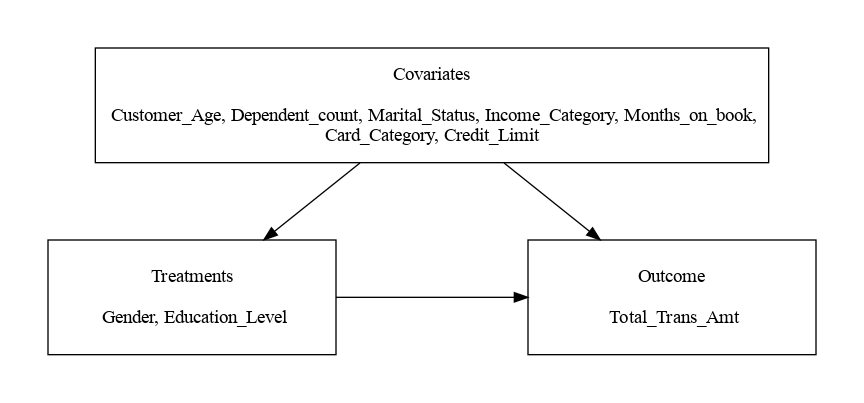

In [17]:
why.plot_causal_graph()

## Estimate causal effect on train_data

In [18]:
why.causal_effect(control=['M','College'])

mean           min  \
Gender          F vs M                    406.626866 -16334.569379   
Education_Level Doctorate vs College      513.555777 -15261.128900   
                Graduate vs College       237.586831 -15306.590172   
                High School vs College    434.868307 -15409.586171   
                Post-Graduate vs College  366.174504 -15187.796393   
                Uneducated vs College     343.300940 -15311.588333   
                Unknown vs College        214.187185 -15124.595100   

                                                   max          std  
Gender          F vs M                    15510.584747  4813.098184  
Education_Level Doctorate vs College      14312.104970  4722.906472  
                Graduate vs College       16048.334966  4421.579541  
                High School vs College    16052.578128  4658.106673  
                Post-Graduate vs College  15567.004489  4640.986284  
                Uneducated vs College     15354.585566  4581.909083  
                Unknown vs College        15540.590368  4371.778955

## Estimate causal effect on test_data

In [19]:
why.causal_effect(test_data, control=['M','College'])

mean           min  \
Gender          F vs M                    400.416773 -15499.642309   
Education_Level Doctorate vs College      661.178857 -14701.608489   
                Graduate vs College       237.804192 -15170.706202   
                High School vs College    489.521115 -15346.590508   
                Post-Graduate vs College  483.465416 -14834.954442   
                Uneducated vs College     303.299251 -15664.424730   
                Unknown vs College        256.288343 -15033.169526   

                                                   max          std  
Gender          F vs M                    15510.584747  4875.212986  
Education_Level Doctorate vs College      14319.936226  4822.661456  
                Graduate vs College       15999.538285  4449.147322  
                High School vs College    15310.397378  4720.221727  
                Post-Graduate vs College  15755.330659  4737.893396  
                Uneducated vs College     15119.889302  4701.585035  
                Unknown vs College        15593.935689  4390.361154